<a href="https://colab.research.google.com/github/Rom1deTroyes/Segmentation_Lesions_Pulmonaires/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://simplonline.co/_next/image?url=https%3A%2F%2Fsimplonline-v3-prod.s3.eu-west-3.amazonaws.com%2Fmedia%2Fimage%2Fjpg%2Fcb4b9733-3fff-43d0-a1c7-e469e016b978.jpg&w=1280&q=75)

# Segmentation des lésions pulmonaires

Ce brief a pour objectif de manipuler une architecture CNN pour réaliser la segmentation.

Dans ce brief, nous appliquons un apprentissage supervisé pour détecter les lésions pulmonaires à partir d’une image.


In [1]:
# Récpération des données
!git clone https://github.com/Rom1deTroyes/Segmentation_Lesions_Pulmonaires  # clone
%cd Segmentation_Lesions_Pulmonaires
#%pip install -qr requirements.txt  # install

Cloning into 'Segmentation_Lesions_Pulmonaires'...
remote: Enumerating objects: 5510, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5510 (delta 12), reused 10 (delta 10), pack-reused 5496
Receiving objects: 100% (5510/5510), 861.56 MiB | 32.06 MiB/s, done.
Resolving deltas: 100% (1744/1744), done.
Checking out files: 100% (5466/5466), done.
/content/Segmentation_Lesions_Pulmonaires


In [2]:
#!pip list --format=freeze

In [3]:
import cv2
import os
import random

import numpy as np

from tqdm.notebook import tqdm

## Partie 1 : Base de données

### Charger les images

#### **Redimensionner** les images selon le modèle souhaité.

In [4]:
width=256
height=256

In [5]:
dir_img="frames/"
dir_mask="masks/"

tab_img=[]
tab_mask=[]

# Récupération de la liste des fichiers images
files = os.listdir(dir_img)
# Mélange des images 
random.Random(42).shuffle(files)

for n, i in tqdm(enumerate(files), total=len(files)):

    tab_img.append(cv2.resize(cv2.imread(dir_img+i), (width, height))/255)

    img_mask=cv2.resize(cv2.imread(dir_mask+i), (width, height))[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 1), dtype=np.float32)  # Image vide (h,w, N) avec N = nombre de classes
    img_mask_result[:,:,0][img_mask==255]=1.  ## Pour toutes les h,w de la profondeur 0 : Quand Couleur 255 (blanc) => Classe 1
    tab_mask.append(img_mask_result)

# Préparation du Tenseur
tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)

  0%|          | 0/2729 [00:00<?, ?it/s]

In [6]:
# Vérification des données importées
print(tab_img.shape)
print(tab_mask.shape)

(2729, 256, 256, 3)
(2729, 256, 256, 1)


On a autant d'images que de masques : tout c'est bien passé.

#### Séparation des données en données d’apprentissage, validation et test.

In [7]:
# Ratios Train / Test / Validation
val_num = 15/100
test_num = 20/100

In [8]:
# Indices des slices
val_split = int(1 - val_num * len(tab_img))
test_split = int(1 - test_num * (len(tab_img) - val_split))

#split Train
x_train = tab_img[0:test_split]
y_train = tab_mask[0:test_split]

#split Test
x_test = tab_img[test_split:val_split]
y_test = tab_mask[test_split:val_split]

#split Validation
x_valid = tab_img[val_split:]
y_valid = tab_mask[val_split:]

# Vérification de la répartition des données
print(x_train.shape, x_test.shape, x_valid.shape)
print(y_train.shape, y_test.shape, y_valid.shape)


-408 -626
(2103, 256, 256, 3) (218, 256, 256, 3) (408, 256, 256, 3)
(2103, 256, 256, 1) (218, 256, 256, 1) (408, 256, 256, 1)


Vérification de la répartition des données Train/Test/Validation

In [48]:
print(f"Apprentissage : {round(x_train.shape[0]*100/len(tab_img))}%")
print(f"Test : {round(x_test.shape[0]*100/x_train.shape[0])}%")
print(f"Validation : {round(x_valid.shape[0]*100/len(tab_img))}%")

Apprentissage : 77%
Test : 10%
Validation : 15%


## Appliquer la data augmentation.

In [9]:
from keras.preprocessing import image

In [10]:
## Code : Amine
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# 0.9 = 90% Train + 10% Validation
tv_split = 0.9

# Apprentissage (+ standardisation)
seed = 42
image_datagen.fit(tab_img[:int(tab_img.shape[0]*tv_split)], augment=True, seed=seed)
mask_datagen.fit(tab_mask[:int(tab_mask.shape[0]*tv_split)], augment=True, seed=seed)

# Application de la Data Augmentation
BATCH_SIZE = 32
x=image_datagen.flow(tab_img[:int(tab_img.shape[0]*tv_split)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(tab_mask[:int(tab_mask.shape[0]*tv_split)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(tab_img[int(tab_img.shape[0]*tv_split):], augment=True, seed=seed)
mask_datagen_val.fit(tab_mask[int(tab_mask.shape[0]*tv_split):], augment=True, seed=seed)

x_val=image_datagen_val.flow(tab_img[int(tab_img.shape[0]*tv_split):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(tab_mask[int(tab_mask.shape[0]*tv_split):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

#### Autre façon de faire (Amine)



```python
Valid_dir_img="Data_Valid/Data/"
Valid_dir_mask="Data_Valid/Gr_Th/"

width=512
height=512
channels=3

Valid_tab_img=[]
Valid_tab_mask=[]

for n, i in tqdm(enumerate(os.listdir(Valid_dir_img)), total=len(os.listdir(Valid_dir_img))):
    Valid_tab_img.append(cv2.resize(cv2.imread(Valid_dir_img+i), (width, height))/255)

    img_mask=cv2.resize(cv2.imread(Valid_dir_mask+i), (width, height))[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 1), dtype=np.float32)
    img_mask_result[:,:,0][img_mask==255]=1.
    Valid_tab_mask.append(img_mask_result)

tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)

Valid_tab_img=np.array(Valid_tab_img)
Valid_tab_mask=np.array(Valid_tab_mask)

from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

seed = 42
image_datagen.fit(tab_img, augment=True, seed=seed)
mask_datagen.fit(tab_mask, augment=True, seed=seed)

BATCH_SIZE = 32
x=image_datagen.flow(tab_img,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(tab_mask,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(Valid_tab_img, augment=True, seed=seed)
mask_datagen_val.fit(Valid_tab_mask, augment=True, seed=seed)

x_val=image_datagen_val.flow(Valid_tab_img,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Valid_tab_mask,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)
```

### Visualiser les images de CT et sa vérité terrain (segmentation manuelle).

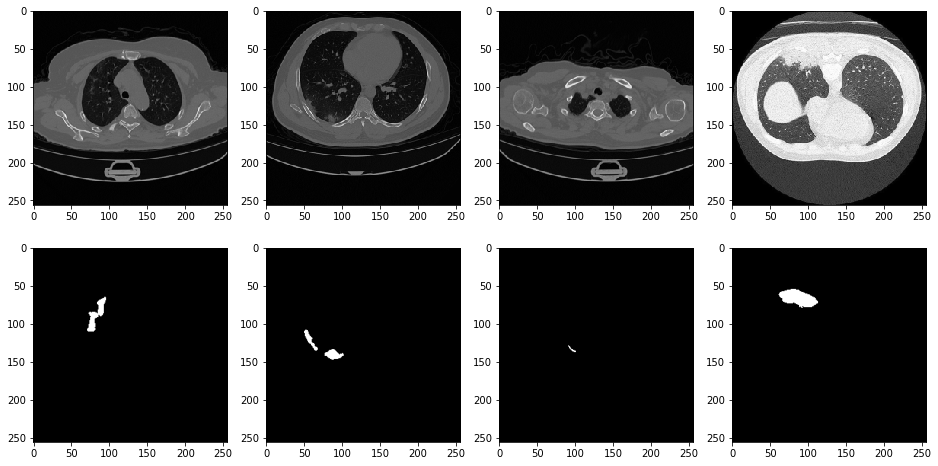

In [11]:
from matplotlib import pyplot as plt

n = 4
h = 4
f, axarr = plt.subplots(2,n, figsize=(h*n,2*h))

for c in range(n):
  r = c * int(len(tab_img)/(n-1))
  axarr[0,c].imshow(tab_img[r], interpolation='nearest')
  axarr[1,c].imshow(tab_mask[r,:,:,0], cmap='gray')



## Partie 2 : Transfer Learning


### Préparation du modèle de segmentation

In [12]:
# Installation des bibliothèques
!pip install -q segmentation-models

     |████████████████████████████████| 50 kB 6.9 MB/s 


In [13]:
# Import des bibliothèques
import segmentation_models as sm
from segmentation_models import Unet

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [14]:
model_path = 'Unet_weights.h5'

#### Définition du modèle et des métriques

In [15]:
n_classes = 1
activation = 'sigmoid' if n_classes == 1 else 'softmax'  # sigmoid si sortie binaire, sinon softmax

width=256
height=256

model = Unet('resnet34', encoder_weights='imagenet', classes=1, input_shape=(width, height, 3), activation=activation)  #  input_shape=(width, height, 3), 

# metrics = ["acc"]
metrics = ["acc", sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# compile keras model with defined optimozer, loss and metrics
model.compile('Adam', loss="binary_crossentropy", metrics=metrics)

# define callbacks for learning rate scheduling and best checkpoints saving
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    ReduceLROnPlateau(),
]


85532672/85521592 [==============================] - 1s 0us/step


In [16]:
from keras.models import load_model
if os.path.exists(model_path) :
    model.load_weights(model_path)  # Rechargement du modèle si déjà enregistré

#### Apprentissage

Application d'un Transfer Learning sur l'architecture.

In [17]:
EPOCHS = 10

results = model.fit(train_generator,
                    steps_per_epoch=1000,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    validation_steps=500
                    )

model.save_weights(model_path)

Epoch 1/10
1000/1000 [==============================] - 820s 793ms/step - loss: 0.0501 - acc: 0.9815 - iou_score: 0.5401 - f1-score: 0.6675 - val_loss: 0.0328 - val_acc: 0.9906 - val_iou_score: 0.3544 - val_f1-score: 0.5207
Epoch 2/10
1000/1000 [==============================] - 776s 777ms/step - loss: 0.0138 - acc: 0.9919 - iou_score: 0.6788 - f1-score: 0.8078 - val_loss: 0.0151 - val_acc: 0.9944 - val_iou_score: 0.6347 - val_f1-score: 0.7743
Epoch 3/10
1000/1000 [==============================] - 774s 774ms/step - loss: 0.0120 - acc: 0.9924 - iou_score: 0.7081 - f1-score: 0.8285 - val_loss: 0.0124 - val_acc: 0.9952 - val_iou_score: 0.6878 - val_f1-score: 0.8140
Epoch 4/10
1000/1000 [==============================] - 810s 811ms/step - loss: 0.0124 - acc: 0.9924 - iou_score: 0.7036 - f1-score: 0.8246 - val_loss: 0.0144 - val_acc: 0.9946 - val_iou_score: 0.6367 - val_f1-score: 0.7762
Epoch 5/10
1000/1000 [==============================] - 792s 793ms/step - loss: 0.0111 - acc: 0.9927 - i

In [18]:
model.save_weights(model_path)

#### Visualisation des métriques

In [19]:
results.history

{'acc': [0.9815385341644287,
  0.9918970465660095,
  0.9924157857894897,
  0.9923507571220398,
  0.9927321672439575,
  0.9923380017280579,
  0.9925134778022766,
  0.9930477142333984,
  0.9931462407112122,
  0.9932763576507568],
 'f1-score': [0.6674961447715759,
  0.8078294992446899,
  0.8284763693809509,
  0.8245774507522583,
  0.8395788073539734,
  0.8241828083992004,
  0.8316513299942017,
  0.8523992896080017,
  0.8565295934677124,
  0.8616954684257507],
 'iou_score': [0.5401369333267212,
  0.6788462400436401,
  0.7080639004707336,
  0.7036285400390625,
  0.7247545123100281,
  0.7047519087791443,
  0.7127576470375061,
  0.743953287601471,
  0.7498461008071899,
  0.7580294609069824],
 'loss': [0.05010369047522545,
  0.01375533826649189,
  0.012010629288852215,
  0.012370100244879723,
  0.011072798632085323,
  0.012540917843580246,
  0.011732972227036953,
  0.010223387740552425,
  0.009851362556219101,
  0.00958073791116476],
 'val_acc': [0.9906498789787292,
  0.9944131970405579,
  0.9

#### Courbes Accuracy, F1-Score, iuo, Loss

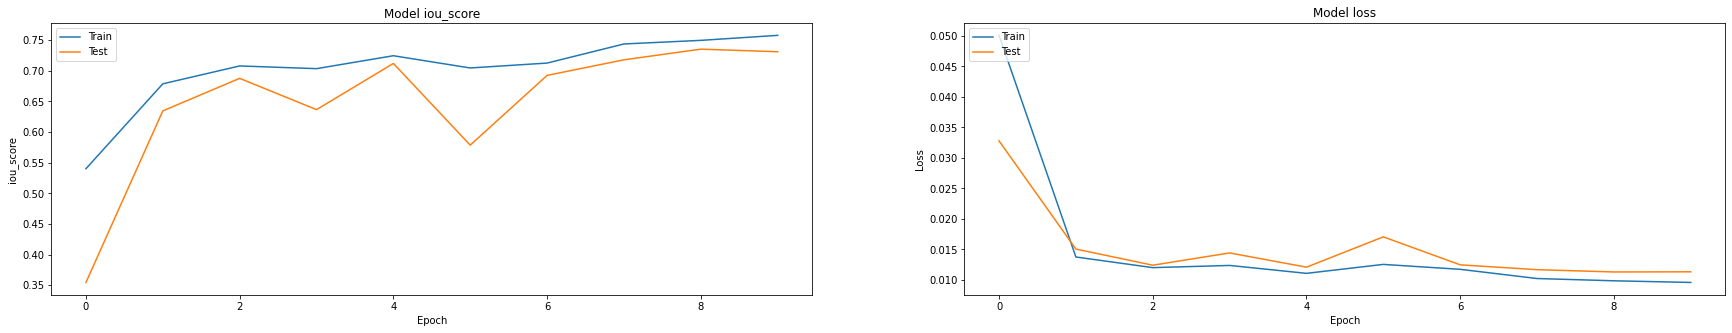

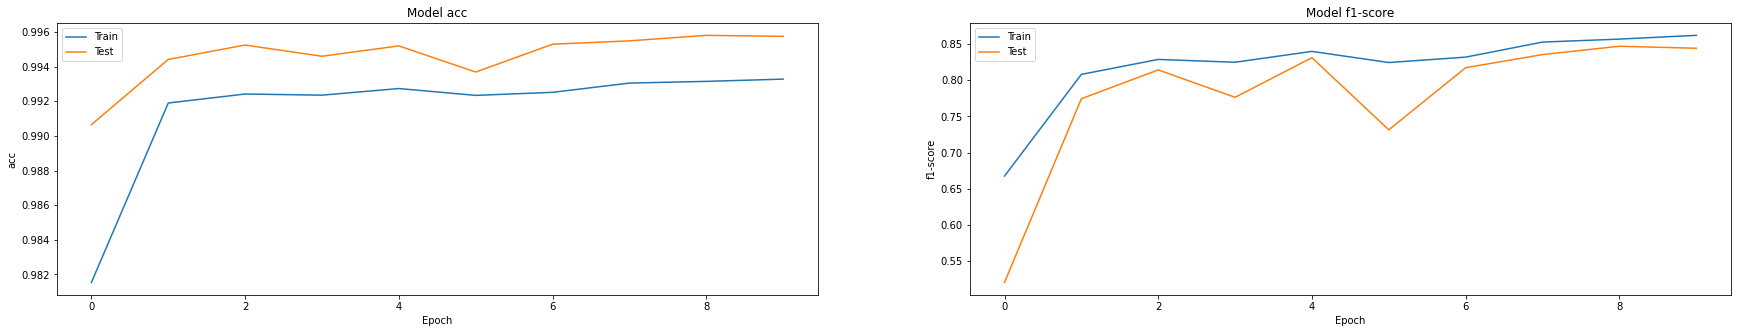

In [20]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(results.history['iou_score'])
plt.plot(results.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation acc values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1-score values
plt.subplot(122)
plt.plot(results.history['f1-score'])
plt.plot(results.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Test

### Affichage de l'image détourée par son masque

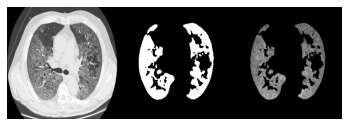

In [21]:
from PIL import Image

#width = height = 256

raw = Image.open('test.png')

raw = np.array(raw.resize((width, height)))/255.
raw = raw[:,:,0:3]

#predict the mask
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#show the mask and the segmented image
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.savefig('test-pred.png', dpi = 300, bbox_inches='tight')
plt.show()

In [34]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Unet_weights.h5
	modified:   test-pred.png

no changes added to commit (use "git add" and/or "git commit -a")


In [36]:
!git add Unet_weights.h5 test-pred.png
!git commit -m '~[Model] update model'

[colab 7f495f4] ~[Model] update model
 2 files changed, 0 insertions(+), 0 deletions(-)
 rewrite test-pred.png (96%)
